## <h3 style="text-align: center;"><b>Classifying Sentiment of Restaurant Reviews </b>

    In this tutorial we will apply the concepts learned in the previous tutorial on a real world task.
    We will use a simple single-layer Neural Network to classify restaurant reviews on Yelp as positive or negative.

In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import defaultdict, Counter, OrderedDict
import torch
import torch.nn as nn
from torchtext.vocab import vocab

In [2]:
# import datasets
yelp = pd.read_csv(r"data\yelp_reviews.csv")

In [3]:
# filter empty rows
yelp = yelp[~pd.isnull(yelp.review)]
yelp.head()

,rating,review,split
0,negative,terrible place to work for i just heard a stor...,train
1,negative,"hours , minutes total time for an extremely s...",train
2,negative,my less than stellar review is for service . w...,train
3,negative,i m granting one star because there s no way t...,train
4,negative,the food here is mediocre at best . i went aft...,train


In [123]:
yelp.split.value_counts()

train    39200
val       8400
test      8400
Name: split, dtype: int64

We create three partitions of the dataset: one for training, one for validation and one for testing.

In [166]:
train_data = yelp[yelp.split=="train"]
valid_data = yelp[yelp.split=="val"]
test_data = yelp[yelp.split=="test"]

In order to enable Neural Network model to interact with text data, we need to covert the review text into a vector of numbers representing the review.\
We design a pipeline to convert text inputs to vectorized minibatches:
1. The pipeline starts with preprocessed text; each data point is a list of tokens, i.e. words in this example;
1. Using training partition of the dataset we build a vocabulary that coordinates integer-to-token mappings;
2. In the vectorization step, the mapping is applied to each data point to create a vector from a review;
3. Finally, PyTorch's DataLoader will be used to group the vectorized reviews into minibatches for the model.

## <h6 style="text-align: center;"><b>Text cleansing</b>

We define a function to clean the review text from punctuation and special symbols.

In [167]:
def tokenize(text):
    """Removing punctuation and special symbols from review text"""
    
    tokens = re.sub("[^a-zA-Z]+", " ", text) 
    return tokens.split()

## <h6 style="text-align: center;"><b>Building token to integer mapping</b>

In [170]:
token_counter = Counter()
        
# extract unique words from the dataset
for _, row in train_data.iterrows():
    tokens = tokenize(row.review)
    token_counter.update(tokens)
    
# set a minimum token frequency to restrict infrequent tokens from the Vocabulary
cutoff = 25

# building Vocabulary
sorted_tokens = token_counter.most_common() # list of tuples (token, cnt)
vocabulary = vocab(OrderedDict(sorted_tokens),
                   min_freq=cutoff,
                   specials = ["<unk>"])

# set <unk> index as default index
unk_index = vocabulary["<unk>"]
vocabulary.set_default_index(unk_index)

In [171]:
len(vocabulary)

7497

## <h6 style="text-align: center;"><b>Vectorization</b>

The second step: transform a review string into a tensor of numbers.\
In this example we will be using a **collapsed one-hot representation**:\
each review is represented as a binary vector, a vector of 1s and 0s, with length equal to the number of words in the Vocabulary.\
The binary vector has 1 in the index position of those words that are present in that review. 
* First, we iterate through the tokens of a single review and use the token-to-integer mapping to convert each token to its vocabulary index.
* Then, we use these integers to fill with 1s the corresponding index positions inside a zero tensor. 

The resulting binary tensor will serve as a numerical representation for a single review.

In [172]:
def vectorize(review):
    """
    Creates a collapsed one-hot tensor for a single text review.
    
    Args:
        review (str): a text review
    Returns:
        one_hot_tensor (torch.FloatTensor): collapsed one-hot representation of a review
    """
    indices = [vocabulary[token] for token in review.split()]
    one_hot_vector = torch.zeros(len(vocabulary), dtype=torch.float32)
    for token_index in indices:
        one_hot_vector[token_index] = 1
    return one_hot_vector

## <h6 style="text-align: center;"><b>Custom Dataset</b>

We create a ReviewsDataset class, that internally converts a single review into a vector representation.\
The class simplifies the access to individual training examples. To build our custom dataset class,\
we must subclass PyTorch's ``Dataset`` class and overwrite its ``__len__`` and ``__getitem__`` methods.

In [173]:
class ReviewsDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset, vocabulary):
        self.dataset = dataset
        self.vocabulary = vocabulary
        self.idx2rating = {index: label for index, label in enumerate(sorted(dataset.rating.unique()))}
        self.rating2idx = {label: index for index, label in self.idx2rating.items()}
        
        
    def __len__(self):
        # return the size of the dataset
        pass
    
    def __getitem__(self, index):
        
        # read one labeled pair from dataframe
        # TODO
        
        # preprocess and vectorize text review
        # TODO
        
        # map label to integer and convert to float tensor
        # TODO 
        
        # return a vectorized inputs-label pair
        pass

In [174]:
train_dataset = ReviewsDataset(train_data, vocabulary)
valid_dataset = ReviewsDataset(valid_data, vocabulary)

## <h6 style="text-align: center;"><b>Data Loader</b>

The final step of the data preparation pipeline is to group vectorized data points into batches.\
We take advantage of PyTorch's ``DataLoader`` class, which expects a ``PyTorch Dataset`` and a ``batch_size`` as its compulsary arguments.

In [175]:
dataloader = torch.utils.data.DataLoader(dataset,
                            batch_size = batch_size,
                            shuffle = shuffle,
                            drop_last = drop_last)

## <h6 style="text-align: center;"><b>Sentiment Classifier</b>

We reimplement the model from the previous tutorial. The Classifier inherits from PyTorch's Module.\
A single linear layer projects a feature tensor into a scalar. 
The sigmoid is used as the final activation to convert linear output into a probability value.

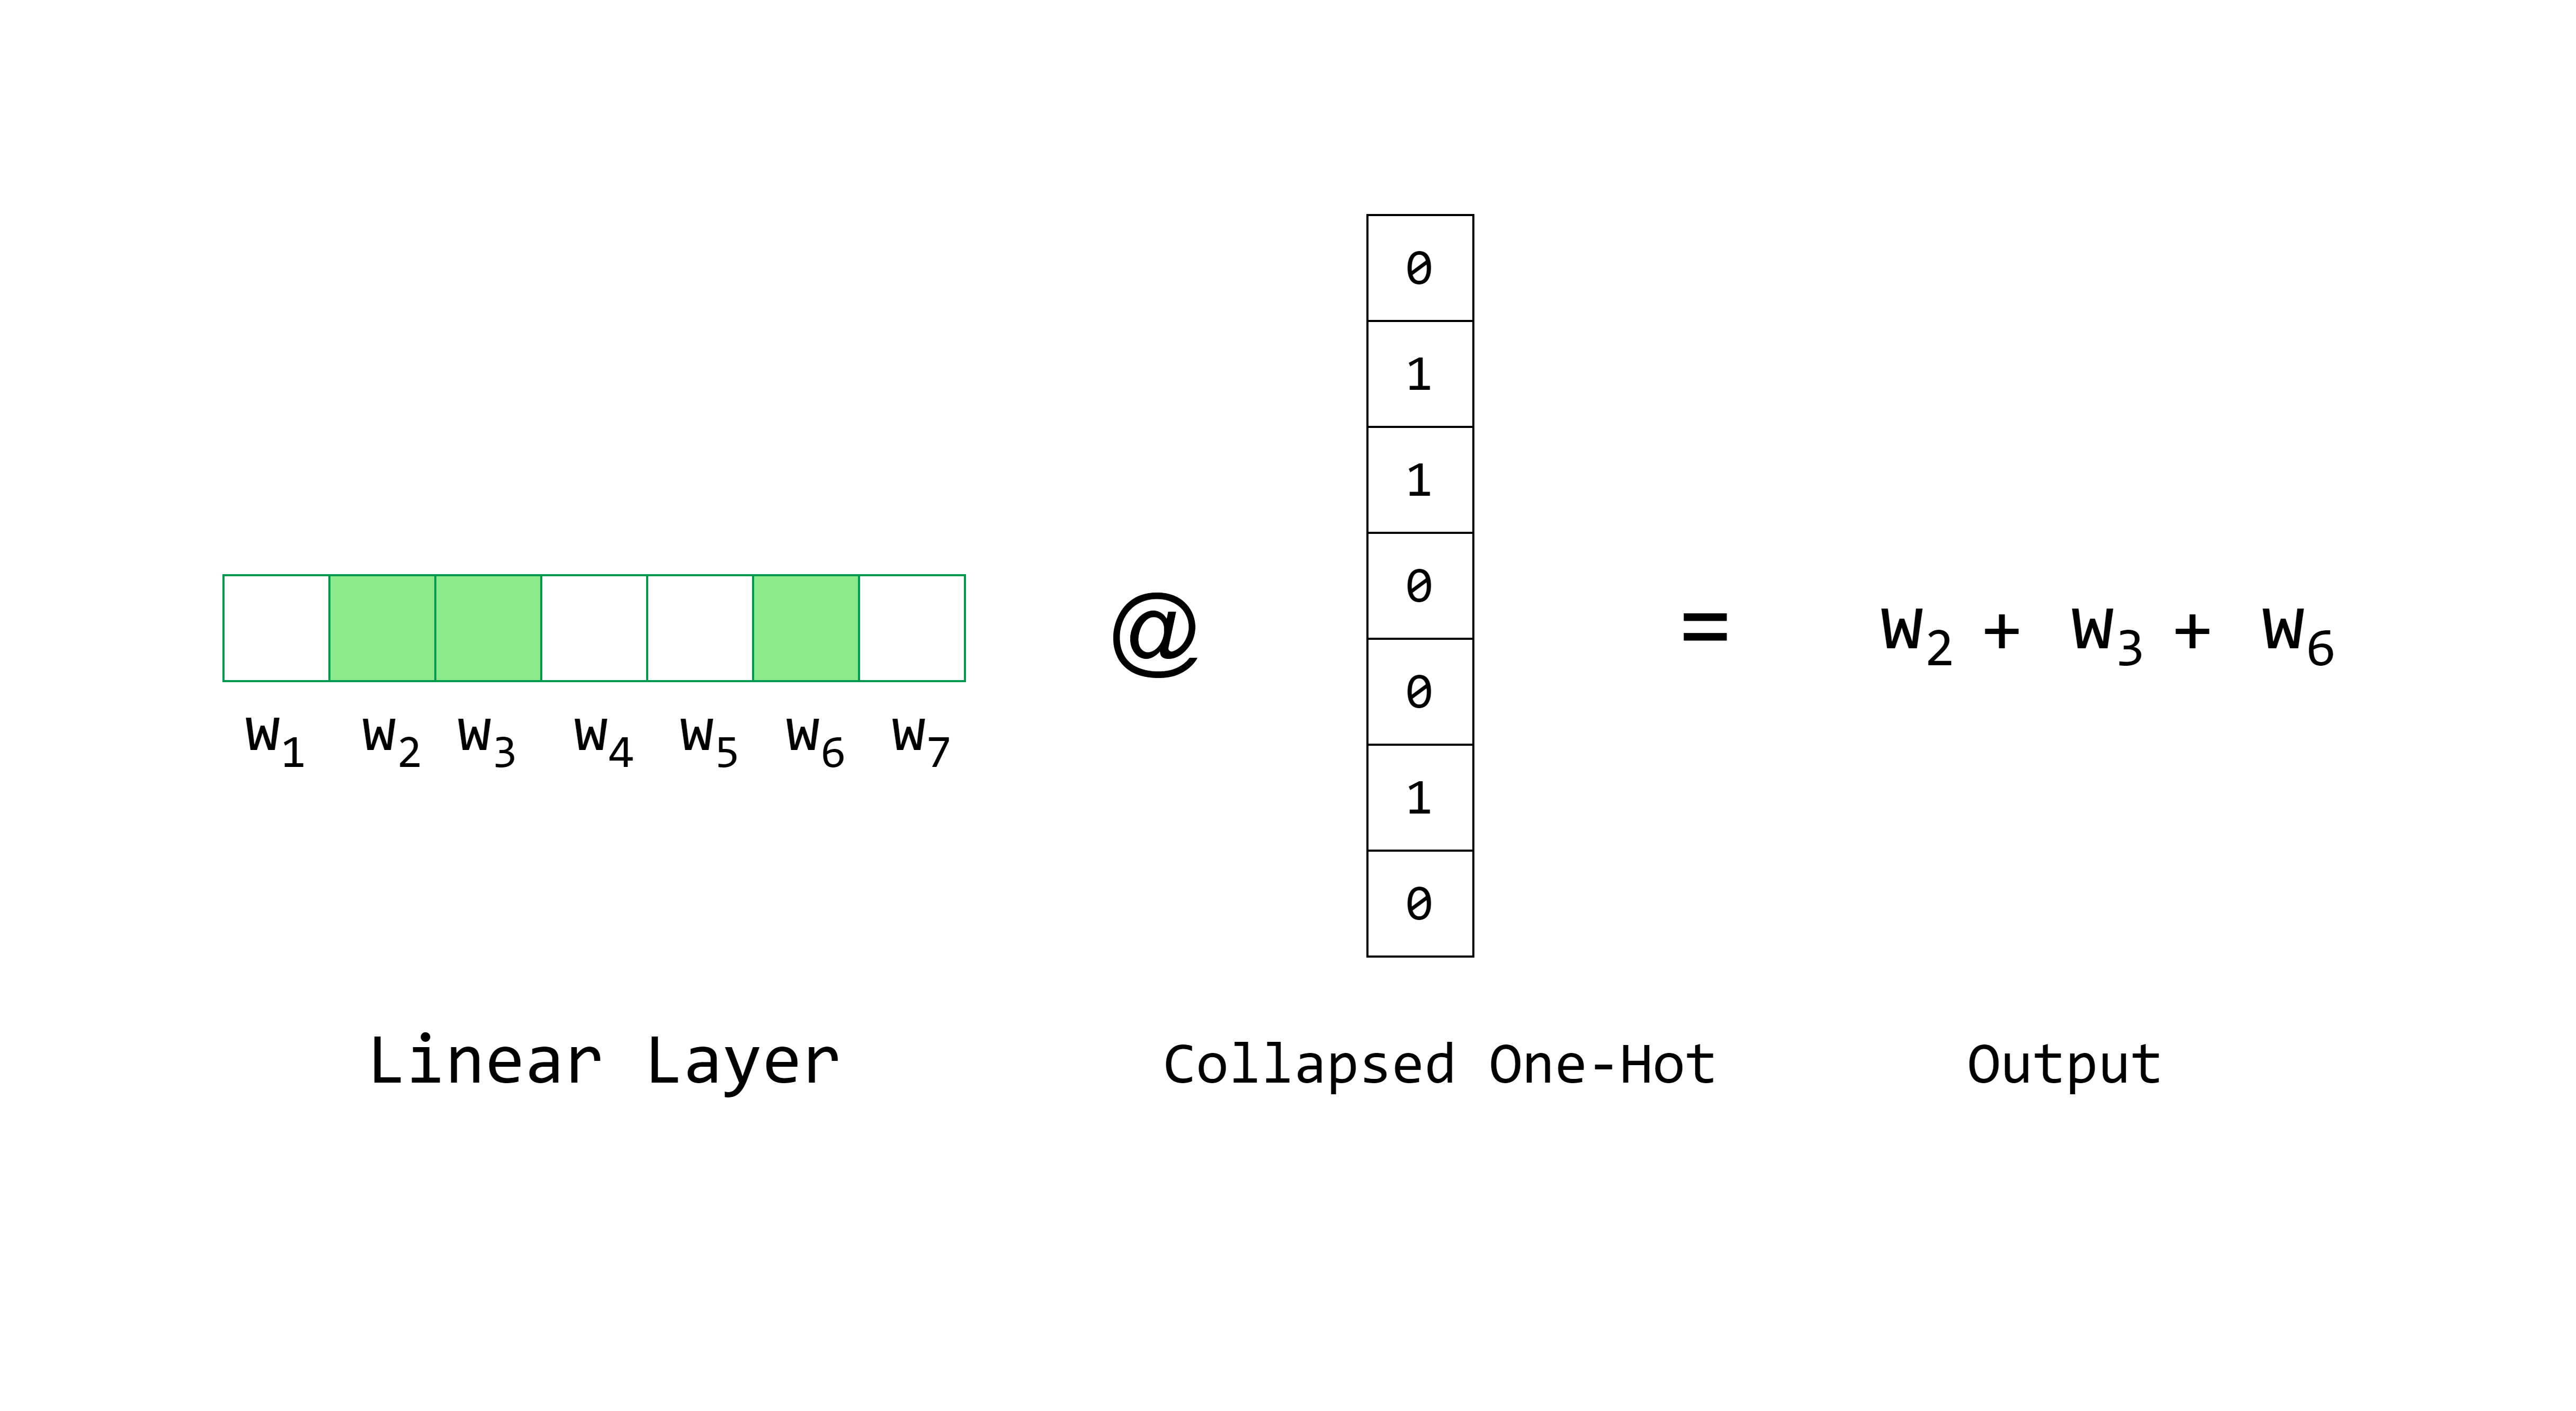

In [176]:
import torch.nn as nn

class Classifier(nn.Module):
    """ 
    A single-layer classifier with sigmoid activation
    
    Args:
        num_features (int): the size of the input feature tensor
    
    """
    def __init__(self, num_features):
        super().__init__()
        # define a linear layer with sigmoid activation
        
    def forward(self, inputs):
        """ Forward pass"""
        # inputs have shape (batch_size, num_features)
        # implement a forward pass
        
        pass

Verify if cuda is available and move the model to the device.

In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier(len(vocabulary)).to(device)

Instantiate Adam optimizer and Binary Cross Entropy loss.

In [178]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
loss_function = torch.nn.BCELoss()

## <h6 style="text-align: center;"><b>Model Training</b>

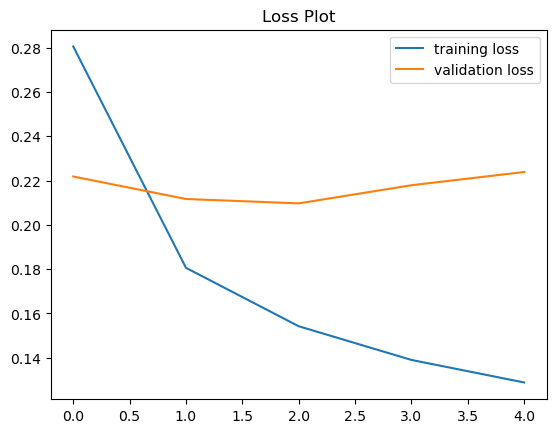

In [179]:
num_epochs = 5
batch_size = 128
loss_dict = defaultdict(list)

for epoch in range(num_epochs):
    
    batch_generator = dataloader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    running_loss = 0
    model.train()
    
    for batch_index, batch in enumerate(batch_generator, start=1):
        
        # step 0. fetch a batch of inputs-labels pairs
        
        # step 1. compute the prediction
        
        # step 2. compute prediction error
        
        # step 3. use the error to compute gradients
        
        # step 4. take the gradient step
        
        # step 5. reset gradients
        
        # step 6. reporting
        batch_loss = loss_value.item()
        running_loss += (batch_loss - running_loss) / batch_index  
        
    loss_dict["training_loss"].append(running_loss)
    
    batch_generator = dataloader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    model.eval()
    running_loss = 0
    for batch_index, batch in enumerate(batch_generator, start=1):
        
        # step 0. fetch inputs-labels batch
        
        # context manager that disables gradient calculation
        with torch.no_grad():
        
            # step 1. compute the prediction
        
            # step 2. compute prediction error
        
            # step 6. reporting
            batch_loss = loss_value.item()
            running_loss += (batch_loss - running_loss) / batch_index  
            
    loss_dict["validation_loss"].append(running_loss)
    clear_output()
    plt.plot(loss_dict["training_loss"], label = "training loss")
    plt.plot(loss_dict["validation_loss"], label = "validation loss")
    plt.legend()
    plt.title('Loss Plot')
    plt.show()

## <h6 style="text-align: center;"><b>Model saving</b>

In [ ]:
torch.save(model.state_dict(), PATH)
# model.load_state_dict(torch.load(PATH))

## <h6 style="text-align: center;"><b>Model evaluation by prediction and weight inspection</b>

In [180]:
def predict_sentiment(review):
    review = preprocess_text(review)
    token_tensor = vectorize(review)
    probability = model(token_tensor.view(1, -1))
    pred_class = "positive" if probability >=0.5 else "negative"
    
    return pred_class

In [183]:
train_data.iloc[1].review

' hours , minutes total time for an extremely simple physical . stay away unless you have hours to waste ! ! ! '

In [185]:
predict_review(train_data.iloc[1].review)

'negative'

In [187]:
neurons = model.linear_layer.weight.data.detach()[0]

In [188]:
import itertools
values, indices = torch.sort(neurons)
indices = indices.numpy().tolist()
tokens = vocabulary.lookup_tokens(indices)
print("Influential words in negative reviews:\n", tokens[:10])
print("Influential words in positive reviews:\n", tokens[::-1][:10])

Influential words in negative reviews:
 ['worst', 'mediocre', 'meh', 'nmaybe', 'bland', 'slowest', 'awful', 'tasteless', 'horrible', 'rude']
Influential words in positive reviews:
 ['pleasantly', 'delicious', 'fantastic', 'amazed', 'deliciousness', 'ngreat', 'hooked', 'jokes', 'chinatown', 'notch']
